In [ ]:
%matplotlib inline

In [ ]:
!pip install dgl

     |████████████████████████████████| 3.0MB 7.8MB/s 


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import os
import pandas as pd
import numpy as np
import dgl
import torch

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs,node_attrs=None)
    return batched_graph, torch.tensor(labels)

def build_subgraphs():
  path='/content/drive/My Drive/dgl/sub_graphs/'
  subgraphs_list = []
  
  for file in os.listdir(path):
    g = dgl.DGLGraph()
    if file.endswith(".gml"):
      gnx=nx.read_gml(path+os.sep+file, label='label', destringizer=None)
      g.from_networkx(gnx)
      subgraphs_list.append(g)
  return subgraphs_list

def create_list_of_pairs(subgraphs,labels):
  pair_list=[]
  for i in range(len(subgraphs)):
    pair_list.append((subgraphs[i],torch.tensor(labels.loc[i])))
  return pair_list



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
subgraphs=build_subgraphs()
labels=pd.read_excel('/content/drive/My Drive/dgl/train_label.xlsx', index=False)
pairs=create_list_of_pairs(subgraphs,labels)

In [ ]:
from dgl.nn.pytorch import GraphConv

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.conv1 = GraphConv(in_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.conv3 = GraphConv(hidden_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, n_classes)



    def forward(self, g):
        h = g.in_degrees().view(-1, 1).float()
        h = F.relu(self.conv1(g, h))
        h = F.relu(self.conv2(g, h))
        h = F.relu(self.conv3(g, h))
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        return F.sigmoid(self.linear(hg))

**Training variables**

In [ ]:
VALIDATION_SPLIT=0.2
BATCH_SIZE=64
EPOCHS=50
KFOLD_SPLIT=2
LEARNING_RATE=0.001



In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split



# Create training and test sets.
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(pairs, batch_size=32, shuffle=True,
                         collate_fn=collate)
train_size=round(len(data_loader.dataset)*(1-VALIDATION_SPLIT))
val_size=round(len(data_loader.dataset)*VALIDATION_SPLIT)
train , validation = torch.utils.data.random_split(data_loader.dataset, (train_size, val_size))

# Create model
model = Classifier(1, 256, 1)
loss_func = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()
epoch_losses = []
train_loss_values=[]
val_loss_values=[]

for epoch in range(EPOCHS):
    epoch_loss = 0
    val_epoch_loss=0
    for iter, (bg, label) in enumerate(train):
        prediction = model(bg)
        label = label.type(dtype=torch.float)
        loss = loss_func(prediction, label.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    for val_iter, (val_bg,val_label) in enumerate(validation):
      val_pred = model(val_bg)
      val_label = val_label.type(dtype=torch.float)
      val_loss = loss_func(val_pred, val_label.unsqueeze(1))
      val_epoch_loss += val_loss.detach().item()

    #calculating epoch per loss
    epoch_loss /= (iter + 1)
    val_epoch_loss /= (val_iter+1)
    train_loss_values.append(epoch_loss)
    val_loss_values.append(val_epoch_loss)
    print('Epoch {}, loss {:.4f} , val_loss {:.4f}'.format(epoch, epoch_loss,val_epoch_loss))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0, loss 0.6840 , val_loss 0.6540
Epoch 1, loss 0.6851 , val_loss 0.6517
Epoch 2, loss 0.6825 , val_loss 0.6516
Epoch 3, loss 0.6834 , val_loss 0.6523
Epoch 4, loss 0.6820 , val_loss 0.6538
Epoch 5, loss 0.6808 , val_loss 0.6525
Epoch 6, loss 0.6820 , val_loss 0.6518
Epoch 7, loss 0.6860 , val_loss 0.6518
Epoch 8, loss 0.6812 , val_loss 0.6517
Epoch 9, loss 0.6820 , val_loss 0.6529
Epoch 10, loss 0.6801 , val_loss 0.6529
Epoch 11, loss 0.6794 , val_loss 0.6515
Epoch 12, loss 0.6800 , val_loss 0.6517
Epoch 13, loss 0.6803 , val_loss 0.6524
Epoch 14, loss 0.6791 , val_loss 0.6522
Epoch 15, loss 0.6787 , val_loss 0.6522
Epoch 16, loss 0.6787 , val_loss 0.6530
Epoch 17, loss 0.6780 , val_loss 0.6528
Epoch 18, loss 0.6776 , val_loss 0.6530
Epoch 19, loss 0.6773 , val_loss 0.6531
Epoch 20, loss 0.6774 , val_loss 0.6535
Epoch 21, loss 0.6774 , val_loss 0.6537
Epoch 22, loss 0.6773 , val_loss 0.6537
Epoch 23, loss 0.6759 , val_loss 0.6522
Epoch 24, loss 0.6805 , val_loss 0.6555
Epoch 25, 

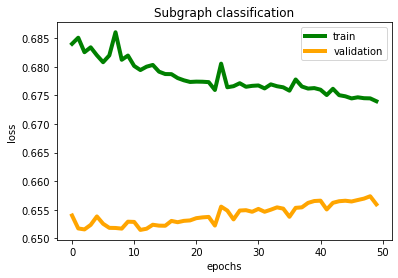

In [ ]:
plt.plot([x for x in range(0,EPOCHS)], train_loss_values,markersize=12, color='green', linewidth=4,label="train")
plt.plot([x for x in range(0,EPOCHS)], val_loss_values, markersize=12, color='orange', linewidth=4,label="validation")
plt.title("Subgraph classification")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()


The learning curve of a run is presented below.



In [ ]:
model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

The animation here plots the probability that a trained model predicts the correct graph type.

![](https://data.dgl.ai/tutorial/batch/test_eval4.gif)


To understand the node and graph representations that a trained model learned,
we use `t-SNE, <https://lvdmaaten.github.io/tsne/>`_ for dimensionality reduction
and visualization.

![](https://data.dgl.ai/tutorial/batch/tsne_node2.png)

    :align: center

![](https://data.dgl.ai/tutorial/batch/tsne_graph2.png)

    :align: center

The two small figures on the top separately visualize node representations after one and two
layers of graph convolution. The figure on the bottom visualizes
the pre-softmax logits for graphs as graph representations.

While the visualization does suggest some clustering effects of the node features,
you would not expect a perfect result. Node degrees are deterministic for
these node features. The graph features are improved when separated.

What's next?
------------
Graph classification with graph neural networks is still a new field.
It's waiting for people to bring more exciting discoveries. The work requires 
mapping different graphs to different embeddings, while preserving
their structural similarity in the embedding space. To learn more about it, see 
`How Powerful Are Graph Neural Networks? <https://arxiv.org/abs/1810.00826>`_ a research paper  
published for the International Conference on Learning Representations 2019.

For more examples about batched graph processing, see the following:

* Tutorials for `Tree LSTM <https://docs.dgl.ai/tutorials/models/2_small_graph/3_tree-lstm.html>`_ and `Deep Generative Models of Graphs <https://docs.dgl.ai/tutorials/models/3_generative_model/5_dgmg.html>`_
* An example implementation of `Junction Tree VAE <https://github.com/dmlc/dgl/tree/master/examples/pytorch/jtnn>`_



'MiniGCDataset'

In [ ]:
len(subgraphs) , len(labels)

(417, 417)